In [1]:
%%time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split

CPU times: user 1.52 s, sys: 281 ms, total: 1.8 s
Wall time: 2.02 s


In [2]:
%%time
data = pd.read_csv("/content/drive/MyDrive/case_study_2/extracted_data.csv")
data.head(3)

CPU times: user 8.21 ms, sys: 4.84 ms, total: 13 ms
Wall time: 410 ms


In [3]:
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head(3)

,corupted_text,normal_text
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...


In [4]:
%%time
def get_length(line):
  '''
  here we calculate the length of each sentence both in corupted_text and normal_txt
  '''
  length = len(line)
  return length

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [5]:
%%time
data["corrupted_length"] = data["corupted_text"].apply(get_length)
data["normal_length"] = data["normal_text"].apply(get_length)

CPU times: user 4.42 ms, sys: 0 ns, total: 4.42 ms
Wall time: 4.23 ms


In [6]:
corupted_length_array = list(data["corrupted_length"].values)
for i in range(90,101):
  print(i,"th percentile",np.percentile(corupted_length_array,i))

90 th percentile 125.0
91 th percentile 129.0
92 th percentile 134.0
93 th percentile 138.0
94 th percentile 142.0
95 th percentile 147.0
96 th percentile 151.0
97 th percentile 154.0
98 th percentile 157.0
99 th percentile 159.0
100 th percentile 221.0


In [7]:
normal_length_array = list(data["normal_length"].values)
for i in range(90,101):
  print(i,"th percentile",np.percentile(normal_length_array,i))

90 th percentile 140.0
91 th percentile 144.0
92 th percentile 149.0
93 th percentile 154.0
94 th percentile 156.0
95 th percentile 162.0
96 th percentile 165.0
97 th percentile 170.0
98 th percentile 179.01999999999998
99 th percentile 190.01
100 th percentile 281.0


In [8]:
%%time
'''
by seeing the 99th percentile of lengths we can cut-short the longer sentences and 
we will take the corrupted sentences whos length is below 170 and target sentence whose length is below 200
'''
data = data[data["corrupted_length"]<171]
data = data[data["normal_length"] <201]
print(data.shape)

(1993, 4)
CPU times: user 7.11 ms, sys: 1.43 ms, total: 8.53 ms
Wall time: 21.2 ms


In [9]:
%%time
# adding \t for start of sentence and \n for end of sentence 
data["normal_text_input"] = '\t '+data['normal_text'].astype(str)
data["normal_text_output"] = data['normal_text'].astype(str)+' \n'

CPU times: user 3.5 ms, sys: 1.93 ms, total: 5.43 ms
Wall time: 6.51 ms


In [10]:
# droping the unecessary columns
data.drop(["normal_text","corrupted_length","normal_length"],axis=1,inplace=True)

In [11]:
data.head(4)

,corupted_text,normal_text_input,normal_text_output
0,"U wan me to ""chop"" seat 4 u nt?",\t Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not? \n
1,Yup. U reaching. We order some durian pastry a...,\t Yeap. You reaching? We ordered some Durian ...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,\t They become more expensive already. Mine is...,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,\t I'm Thai. What do you do?,I'm Thai. What do you do? \n


In [12]:
preprocessed_data = data.copy()
preprocessed_data.iloc[0]['normal_text_input']=str(preprocessed_data.iloc[0]['normal_text_input'])+' \n'
preprocessed_data.iloc[0]['normal_text_output']=str(preprocessed_data.iloc[0]['normal_text_output'])+' \n'

In [13]:
# spliting into train and test
train_data,test_data= train_test_split(preprocessed_data,test_size=0.01, random_state=42)

In [14]:
print(train_data.shape,"===>",test_data.shape)

(1973, 3) ===> (20, 3)


preparing data for model using train data

In [15]:
%%time
# now we need to create vocabulary
# the follwing code is inspired by https://keras.io/examples/nlp/lstm_seq2seq/
input_characters = set()
output_characters = set()

input_sentences = list(train_data["corupted_text"].values)
output_sentences = list(train_data["normal_text_input"].values)
for line in input_sentences:
  for char in line:
    input_characters.add(char)

for line in output_sentences:
  for char in line:
    output_characters.add(char)
input_charcters_list = sorted(list(input_characters))
output_characters_list = sorted(list(output_characters))
print(len(input_charcters_list),len(output_characters_list))

103 92
CPU times: user 27.9 ms, sys: 872 µs, total: 28.7 ms
Wall time: 30.9 ms


In [16]:
input_sentences = list(train_data["corupted_text"].values)
max_encoder_seq_length = max([len(txt) for txt in input_sentences])
max_encoder_seq_length

161

In [17]:
output_sentences = list(train_data["normal_text_output"].values)
max_decoder_seq_length = max([len(txt) for txt in output_sentences])
max_decoder_seq_length

202

In [20]:
input_token_index = dict((c, i) for i, c in enumerate(input_charcters_list))   
output_token_index=dict((c, i) for i, c in enumerate(output_characters_list))
print(len(input_token_index))
print(len(output_token_index))

103
92


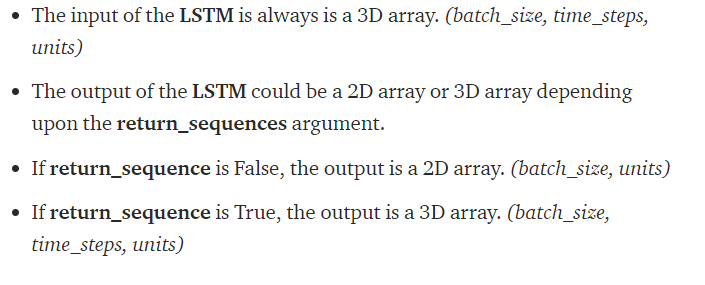

In [21]:
# lets prepare data for model
#intialising np.array with zeros for one hot encoding.
encoder_input_data = np.zeros((len(train_data),170,len(input_token_index)), dtype="int32")

decoder_input_data = np.zeros((len(train_data),202,len(output_token_index)), dtype="int32")
decoder_output_data = np.zeros((len(train_data),202,len(output_token_index)), dtype="int32") 


In [22]:
%%time
#one hot encoding of encoder input data
for i,input_text in enumerate(list(train_data['corupted_text'].values)):
    for t,char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]]=1
    encoder_input_data[i,t+1,input_token_index[" "]]=1   
#one hot encoding of decoder input data and decoder output data   
for i,output_text in enumerate(list(train_data['normal_text_output'].values)):
    for t,char in enumerate(output_text):
        decoder_input_data[i,t,output_token_index[char]]=1
        if t > 0:
        # decoder_target_data will be ahead by one timestep
        # and will not include the start character.
            decoder_output_data[i, t - 1, output_token_index[char]] = 1
    decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
    decoder_output_data[i, t:, output_token_index[" "]] = 1  

CPU times: user 145 ms, sys: 437 µs, total: 146 ms
Wall time: 146 ms


preparing data for validation

In [23]:
# lets prepare data for model
#intialising np.array with zeros for one hot encoding.
val_encoder_input_data = np.zeros((len(test_data),170,len(input_token_index)), dtype="int32")
val_decoder_input_data = np.zeros((len(test_data),202,len(output_token_index)), dtype="int32")
val_decoder_output_data = np.zeros((len(test_data),202,len(output_token_index)), dtype="int32") 


In [24]:
%%time
#one hot encoding of encoder input data
for i,input_text in enumerate(list(test_data['corupted_text'].values)):
    for t,char in enumerate(input_text):
        val_encoder_input_data[i,t,input_token_index[char]]=1
    val_encoder_input_data[i,t+1,input_token_index[" "]]=1   
#one hot encoding of decoder input data and decoder output data   
for i,output_text in enumerate(list(test_data['normal_text_output'].values)):
    for t,char in enumerate(output_text):
        val_decoder_input_data[i,t,output_token_index[char]]=1
        if t > 0:
        # decoder_target_data will be ahead by one timestep
        # and will not include the start character.
            val_decoder_output_data[i, t - 1, output_token_index[char]] = 1
    val_decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
    val_decoder_output_data[i, t:, output_token_index[" "]] = 1  

CPU times: user 3.15 ms, sys: 0 ns, total: 3.15 ms
Wall time: 4.42 ms


In [26]:
tf.keras.backend.clear_session()
encoder_inputs = tf.keras.Input(shape=(None,len(input_token_index)))
encoder = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs,state_h,state_c= encoder(encoder_inputs)
#storing encoder states
encoder_states = [state_h,state_c]
 
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = tf.keras.Input(shape=(None, len(output_token_index)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(len(output_token_index), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
 
# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 103)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 81600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  77200       input_2[0][0]                    
                                                                 lstm[0][1]                   

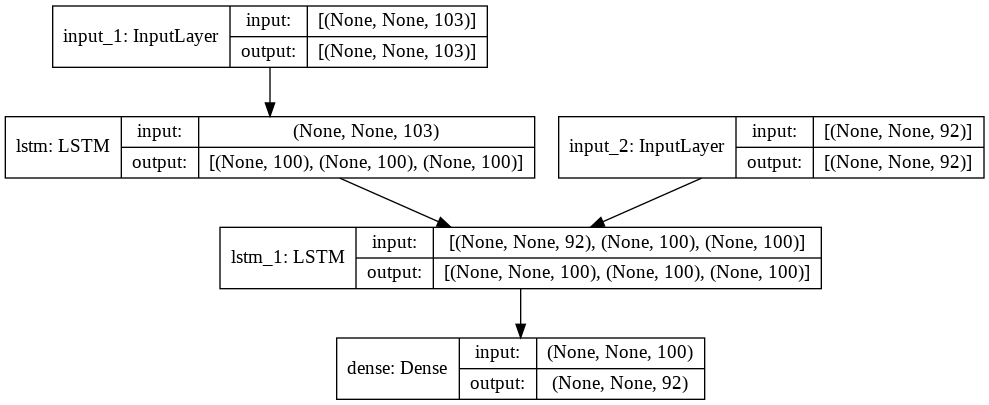

In [59]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [27]:

optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [28]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_split=0.1,batch_size=64,epochs=50)

Epoch 1/50
28/28 [==============================] - 10s 58ms/step - loss: 1.8740 - val_loss: 1.2208
Epoch 2/50
28/28 [==============================] - 1s 30ms/step - loss: 1.2124 - val_loss: 1.0604
Epoch 3/50
28/28 [==============================] - 1s 31ms/step - loss: 1.0520 - val_loss: 0.9313
Epoch 4/50
28/28 [==============================] - 1s 31ms/step - loss: 0.9296 - val_loss: 0.8380
Epoch 5/50
28/28 [==============================] - 1s 30ms/step - loss: 0.8583 - val_loss: 0.7853
Epoch 6/50
28/28 [==============================] - 1s 30ms/step - loss: 0.8158 - val_loss: 0.7535
Epoch 7/50
28/28 [==============================] - 1s 31ms/step - loss: 0.7854 - val_loss: 0.7297
Epoch 8/50
28/28 [==============================] - 1s 30ms/step - loss: 0.7623 - val_loss: 0.7122
Epoch 9/50
28/28 [==============================] - 1s 30ms/step - loss: 0.7409 - val_loss: 0.6917
Epoch 10/50
28/28 [==============================] - 1s 30ms/step - loss: 0.7230 - val_loss: 0.6769
Epoch 11

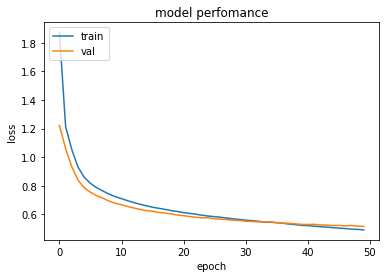

In [60]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model perfomance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc,state_c_enc = model.layers[2].output  # lstm
encoder_states = [state_h_enc,state_c_enc]
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)


decoder_inputs=model.inputs[1]
decoder_state_input_h= tf.keras.Input(shape=(100,))
decoder_state_input_c= tf.keras.Input(shape=(100,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm =model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [42]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in output_token_index.items())


In [49]:
# this code is inspired by the keras blog https://keras.io/examples/nlp/lstm_seq2seq/#run-inference-sampling
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 92))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 92))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [56]:
encoder_input_data[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [61]:
for seq_index in range(20):
    # Take one sequence (part of the test set)
    # for trying out decoding.
    input_seq = val_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-"*50)
    print("Input sentence:", test_data['normal_text_output'].iloc[seq_index])
    print("Decoded sentence:", decoded_sentence)

--------------------------------------------------
Input sentence: Yeah. That day I checked, did not have. So how? Where do you want? 

Decoded sentence: at all the place to meet you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all as
--------------------------------------------------
Input sentence: I think you can, just get the address from your friends first. Haha, I did a lot of shopping. Felt quite bad, because Aust shop a lot already. 

Decoded sentence: at all the place to meet you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all ask you all as
--------------------------------------------------
Input sentence: Oh, want to go there? 

Decoded sentence: op you are going to chat? 

--------------------------------------------------
Input sentence: Are 

predection